# Libraries and options

In [1]:
#pd.set_option('display.float_format', '{:.5f}'.format)

In [2]:
Sys.setenv(DOWNLOAD_STATIC_LIBV8=1)
install.packages("V8")
remotes::install_github("ddsjoberg/gtsummary")

Installing package into ‘/home/olivier/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Skipping install of 'gtsummary' from a github remote, the SHA1 (30ef7175) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# load LMER libraries
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(glmmTMB)
library(emmeans)
library(car)
library(DHARMa)
library(sjPlot) 
library(sjmisc)
library(sjlabelled)
library(effects)
library(performance)  # Loading the performance package
library(yaml)  # To load yaml config file
library(arrow) # To load feather file
library(jtools) # To report results
library(equatiomatic) # Not in CRAN anymore need to wait for update here: https://github.com/datalorax/equatiomatic/issues/224
library(mclust)
library(stargazer)
library(summarytools)
library(gtsummary)
library(gt)

Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in checkMatrixPackageVersion():
“Package version inconsistency detected.
TMB was built with Matrix version 1.5.4.1
Current Matrix version is 1.6.1
Please re-install 'TMB' from source using install.packages('TMB', type = 'source') or ask CRAN for a binary version of 'TMB' matching CRAN's 'Matrix' package”
Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')


Attaching package: ‘sjlabelled’


The following 

In [4]:
theme_set(theme_sjplot())

browser = '/usr/bin/firefox'

utils::browseURL

function (url, browser = getOption("browser"), encodeIfNeeded = FALSE) 
{
    WINDOWS <- .Platform$OS.type == "windows"
    if (!is.character(url) || length(url) != 1L || !nzchar(url)) 
        stop("'url' must be a non-empty character string")
    if (identical(browser, "false")) 
        return(invisible())
    if (WINDOWS && is.null(browser)) 
        return(shell.exec(url))
    if (is.function(browser)) 
        return(invisible(browser(if (encodeIfNeeded) URLencode(url) else url)))
    if (!is.character(browser) || length(browser) != 1L || !nzchar(browser)) 
        stop("'browser' must be a non-empty character string")
    if (WINDOWS) {
        return(system(paste0("\"", browser, "\" ", if (encodeIfNeeded) URLencode(url) else url), 
            wait = FALSE))
    }
    if (.Platform$GUI == "AQUA" || length(grep("^(localhost|):", 
        Sys.getenv("DISPLAY")))) 
        isLocal <- TRUE
    else isLocal <- FALSE
    .shQuote <- function(string) paste0("\"", gsub("$", "\\$", 
        string, fixed = TRUE), "\"")
    quotedUrl <- .shQuote(if (encodeIfNeeded) 
        URLencode(url)
    else url)
    remoteCmd <- if (isLocal) 
        switch(basename(browser), `gnome-moz-remote` = , open = quotedUrl, 
            galeon = paste("-x", quotedUrl), kfmclient = paste("openURL", 
                quotedUrl), mozilla = , opera = {
                paste0("-remote \"openURL(", gsub("([,)$])", 
                  "%\\1", url), ")\"")
            }, quotedUrl)
    else quotedUrl
    system(paste(browser, remoteCmd, "> /dev/null 2>&1 ||", browser, 
        quotedUrl, "&"))
}
<environment: namespace:utils>

# Loading data

In [5]:
# Load the configuration file
config_path <- './config/config.yaml'
config <- tryCatch(
  yaml::read_yaml(config_path),
  error = function(e) {
    stop("Error reading YAML file: ", e$message)
  }
)

# Extract relevant information from the configuration
sample_size <- config$datasets$sample_size
final_data_folder <- config$datasets$pickle_folder
df_R_data_filename <- config$datasets$df_R_filename

# Construct the final data file path
df_R_data_file <- paste0(df_R_data_filename, "_", sample_size, ".feather")
final_data_location <- file.path(final_data_folder, df_R_data_file)


# Print the final data file location

# Read the Feather file
df <- arrow::read_feather(final_data_location)
str(df)

tibble [49,994 × 42] (S3: tbl_df/tbl/data.frame)
 $ t_id                    : chr [1:49994] "1575251731515994114" "1443224010930614272" "1574874734034034706" "1575552603152257025" ...
 $ t_text                  : chr [1:49994] "Bingo. And it’s not just the hijab… But birth control and abortion and driving laws and divorce. It’s almost li"| __truncated__ "So weird how San Francisco tech bros are moving to places where abortion is (or is about to be) illegal 🧐" "In 2019, #DougMastriano said women who violated proposed abortion ban should be charged with murder. #GOPWarOnW"| __truncated__ "\"It's a really strong step forward if the goal is to make California sort of this sanctuary state for abortion"| __truncated__ ...
 $ t_retweet_count         : int [1:49994] 0 0 0 6 7 25 0 0 0 12 ...
 $ t_reply_count           : int [1:49994] 0 0 0 0 0 7 0 0 2 2 ...
 $ t_like_count            : int [1:49994] 3 3 0 18 25 67 0 1 6 28 ...
 $ t_quote_count           : int [1:49994] 0 0 0 3 0 3 0 0 2 1 ...


In [6]:
result <- table(df$category)

# To display the result
print(result)


   abortion        both miscarriage 
      45933         406        3655 


## Subsetting the df to only use the including

In [7]:
df <- df[df$analysis, ]
df <- droplevels(df)

In [8]:
result <- table(df$category)

# To display the result
print(result)


   abortion miscarriage 
      32056        2567 


## Setting variables type

In [9]:
# Refactoring 
df$a_id <- as.factor(df$a_id)
df$t_year <- as.factor(df$t_year)
df$t_year <- relevel(df$t_year, ref = '2021')
df$t_event_noyear <- as.factor(df$t_event_noyear)
df$t_event <- as.factor(df$t_event)
df$a_gender <- relevel(as.factor(df$a_gender), ref = "Man")
df$category <- relevel(as.factor(df$category), ref='abortion')

In [10]:
tbl <- df %>%
  select(t_year, a_gender, category) %>%
  tbl_summary()
# Save the table to an HTML file
tbl |>
  as_gt() |>
  gtsave(file = "results/tables/summary_cat_var.html")

In [11]:
tbl <-
  tbl_summary(
    df,
    include = c(t_year, category),
    by = a_gender, # split table by group
    missing = "no" # don't list missing data separately
  ) 
tbl |>
  as_gt() |>
  gtsave(file = "results/tables/summary_cat_var_gender.html")

# RQ1 

## Polarity analysis

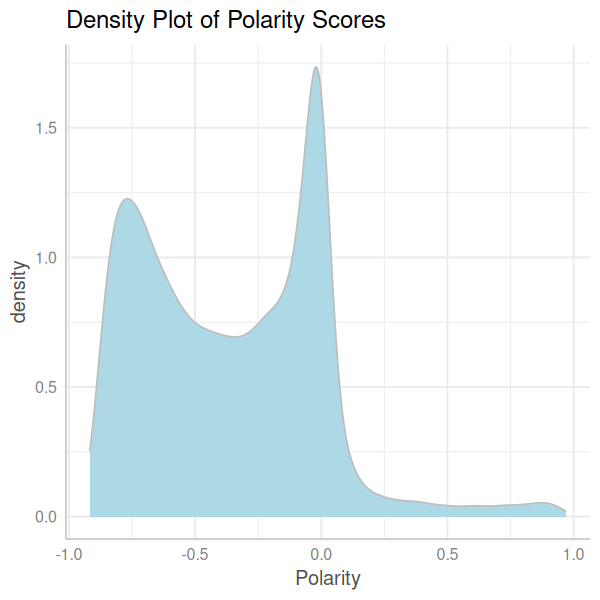

In [20]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(df, aes(x = t_polarity)) +
  geom_density(fill = "lightblue", color = "grey") +
  ggtitle("Density Plot of Polarity Scores") +
  xlab("Polarity")

In [21]:
options(repr.plot.width=5, repr.plot.height=5)
plot_pol <- ggplot(df, aes(x = t_polarity)) +
  geom_density(fill = "lightblue", color = "grey") +
  ggtitle("Density Plot of Polarity Scores") +
  xlab("Polarity")

filename = './results/plots/polarity.pdf'
ggsave(filename, plot = plot_pol, device = "pdf", width = 5, height = 5)

In [38]:
rq1_pol <- lm(t_polarity ~ a_gender + category + t_year + t_year:category + t_year:a_gender, data = df)

In [39]:
summary(rq1_pol)


Call:
lm(formula = t_polarity ~ a_gender + category + t_year + t_year:category + 
    t_year:a_gender, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58388 -0.31981 -0.00836  0.29406  1.32781 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.348300   0.005932 -58.711  < 2e-16 ***
a_genderWoman                   0.015268   0.007000   2.181  0.02917 *  
categorymiscarriage            -0.027903   0.009967  -2.800  0.00512 ** 
t_year2022                     -0.012779   0.007204  -1.774  0.07609 .  
categorymiscarriage:t_year2022  0.067712   0.014771   4.584 4.58e-06 ***
a_genderWoman:t_year2022       -0.015758   0.008622  -1.828  0.06763 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3554 on 34617 degrees of freedom
Multiple R-squared:  0.001359,	Adjusted R-squared:  0.001215 
F-statistic: 9.425 on 5 and 34617 DF,  p-value: 5.434e-09


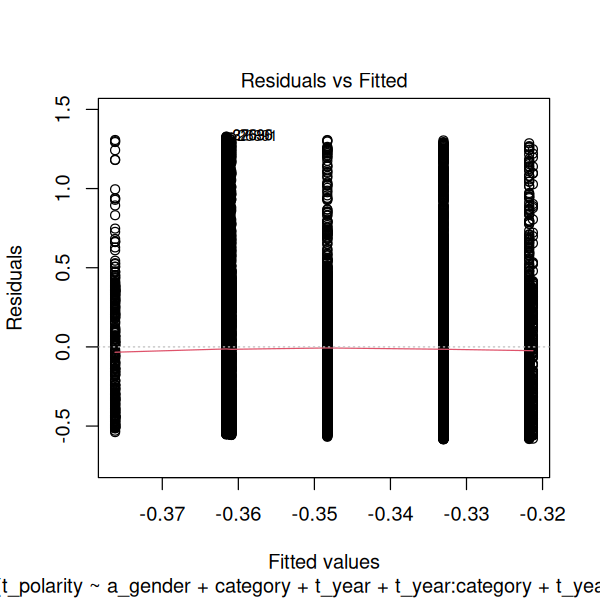

In [40]:
options(repr.plot.width=5, repr.plot.height=5)

plot(rq1_pol, which = c(1))

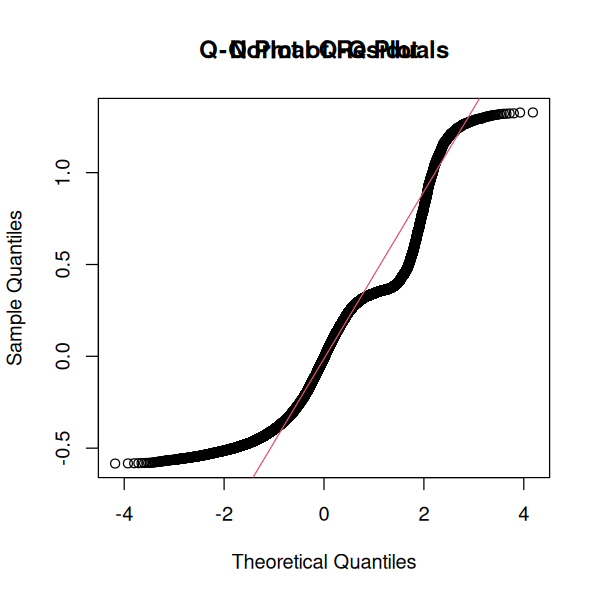

In [41]:
# Extract the residuals
residuals <- residuals(rq1_pol)

# Create a Q-Q plot for the residuals
qqnorm(residuals)
qqline(residuals, col = 2)  # Add a reference line
title("Q-Q Plot of Residuals")

## Subjectivity 

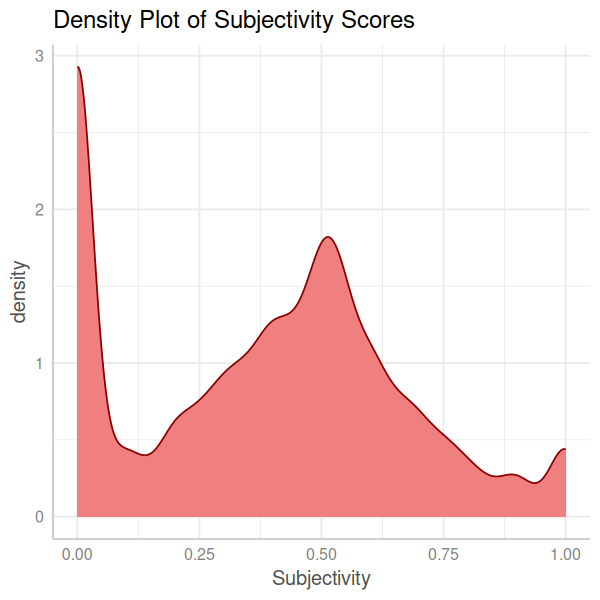

In [42]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(df, aes(x = t_subjectivity)) +
  geom_density(fill = "lightcoral", color = "darkred") +
  ggtitle("Density Plot of Subjectivity Scores") +
  xlab("Subjectivity")

In [18]:
options(repr.plot.width=5, repr.plot.height=5)

plot_subj <-ggplot(df, aes(x = t_subjectivity)) +
  geom_density(fill = "lightcoral", color = "darkred") +
  ggtitle("Density Plot of Subjectivity Scores") +
  xlab("Subjectivity")
filename = './results/plots/subjectivity.pdf'
ggsave(filename, plot = plot_subj, device = "pdf", width = 5, height = 5)

In [43]:
rq1_sub_simple <- lm(t_subjectivity ~1, data = df)

In [58]:
rq1_sub_mixed_model <- lm(t_subjectivity ~a_gender + category + t_year + t_year:category + t_year:a_gender, data=df)

In [59]:
anova(rq1_sub_simple, rq1_sub_mixed_model)

Res.Df RSS      Df Sum of Sq F        Pr(>F)      
1 34622  2788.409 NA       NA        NA           NA
2 34617  2784.652  5 3.756872  9.340602 6.622104e-09

In [60]:
summary(rq1_sub_mixed_model)


Call:
lm(formula = t_subjectivity ~ a_gender + category + t_year + 
    t_year:category + t_year:a_gender, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.42147 -0.28467  0.02842  0.18572  0.62842 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.375463   0.004734  79.305  < 2e-16 ***
a_genderWoman                  -0.003883   0.005586  -0.695    0.487    
categorymiscarriage             0.035775   0.007954   4.498 6.89e-06 ***
t_year2022                      0.005482   0.005749   0.953    0.340    
categorymiscarriage:t_year2022  0.001017   0.011788   0.086    0.931    
a_genderWoman:t_year2022        0.007613   0.006881   1.106    0.269    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2836 on 34617 degrees of freedom
Multiple R-squared:  0.001347,	Adjusted R-squared:  0.001203 
F-statistic: 9.341 on 5 and 34617 DF,  p-value: 6.622e-09


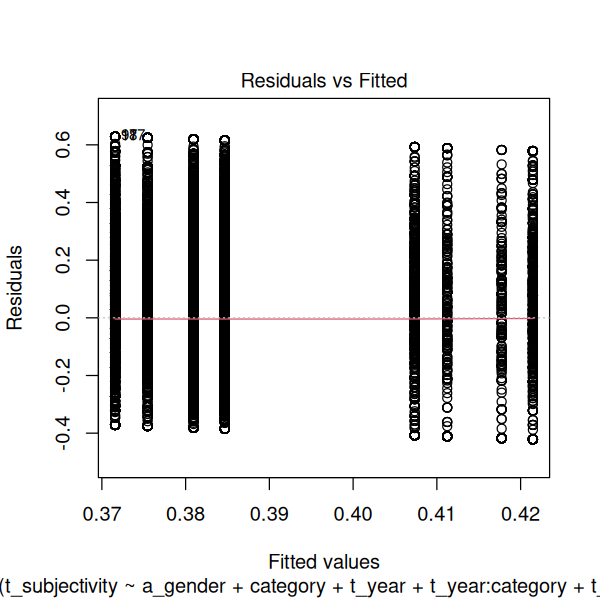

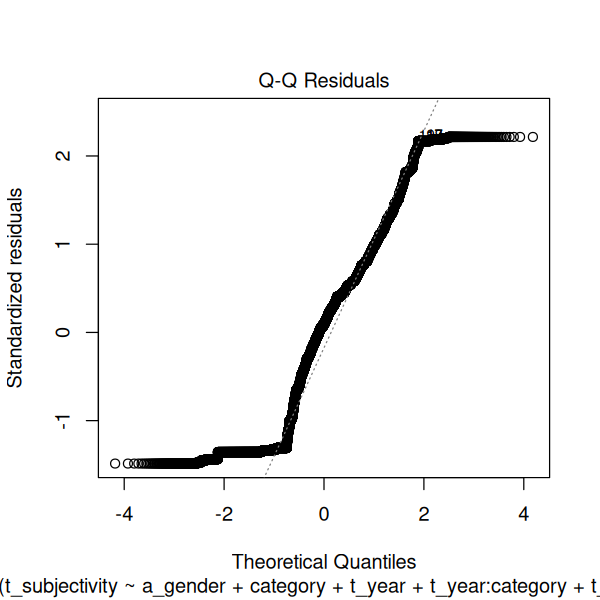

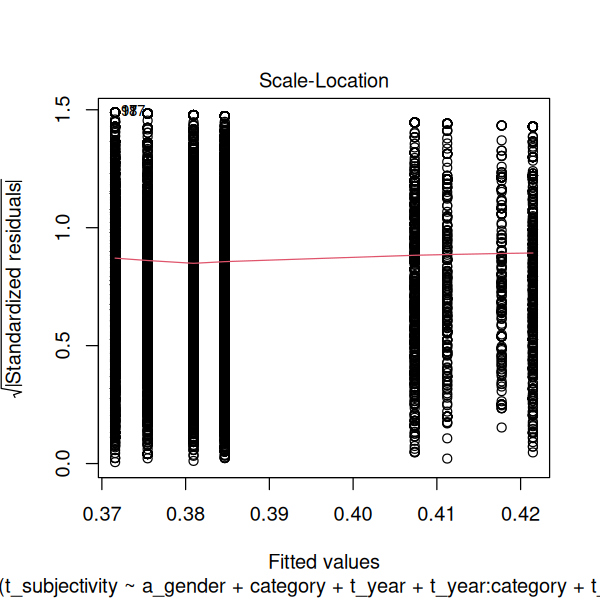

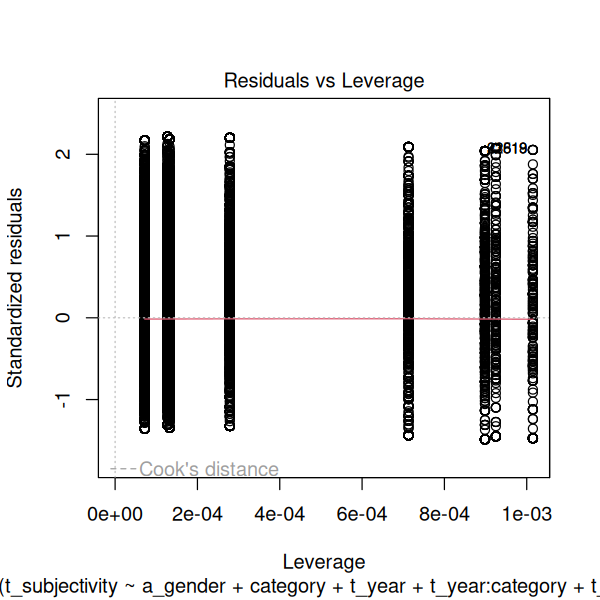

In [61]:
plot(rq1_sub_mixed_model)

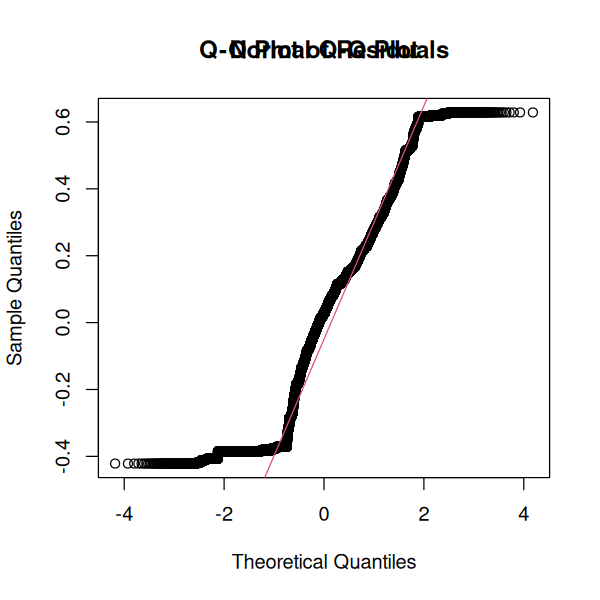

In [62]:
# Extract the residuals
residuals <- residuals(rq1_sub_mixed_model)

# Create a Q-Q plot for the residuals
qqnorm(residuals)
qqline(residuals, col = 2)  # Add a reference line
title("Q-Q Plot of Residuals")

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

# Create a data frame with observed, predicted, and residuals
predictions <- data.frame(observed = df$t_subjectivity,
                           predicted = predict(rq1_sub_mixed_model),
                           residuals = residuals(rq1_sub_mixed_model))

# Plot observed vs. predicted
plot( predictions$observed,predictions$predicted,
     xlab = "Observed Subjectivity",
     ylab = "Predicted Subjectivity",
     main = "Observed vs. Predicted Subjectivity")

# Add a line for y = x to show perfect prediction
abline(a = 0, b = 1, col = "red")

# Plot residuals vs. predicted
plot(predictions$predicted, predictions$residuals,
     xlab = "Predicted Subjectivity",
     ylab = "Residuals",
     main = "Residuals vs. Predicted Subjectivity")


In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

plot(rq1_sub_mixed_model, which = c(1))

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

influencePlot(rq1_sub_mixed_model)

# Retweet analysis

## Formula

In [63]:
DV = "t_retweet_count_agg"

In [74]:
# Unadjusted formula with only the main interaction
rt_unadjusted_formula_string = paste(DV, " ~ t_pol_pos + t_pol_neg +  + t_subjectivity + a_gender  + category + (1| a_id)")
rt_unadjusted_formula <- as.formula(rt_unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
rt_adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand+ t_year"
rt_complete_adjusted_formula_string = paste0(rt_unadjusted_formula_string, rt_adjusted_formula_string)
rt_adjusted_formula <- as.formula(rt_complete_adjusted_formula_string)

# Full interactions formula
rt_full_formula_string <- "+ t_pol_pos:t_subjectivity + t_pol_pos:a_gender + t_pol_pos:category + t_pol_neg:t_subjectivity + t_pol_neg:a_gender + t_pol_neg:category + t_subjectivity:a_gender + t_subjectivity:category"
rt_complete_full_formula_string <- paste0(rt_unadjusted_formula_string, rt_adjusted_formula_string, rt_full_formula_string)

rt_full_formula <- as.formula(rt_complete_full_formula_string)


# Triple interaction

rt_triple_formula_string <- "+ t_pol_pos:t_subjectivity:category"
rt_complete_triple_formula_string <- paste0(rt_unadjusted_formula_string, rt_adjusted_formula_string, rt_full_formula_string, rt_triple_formula_string)

rt_triple_formula <- as.formula(rt_complete_triple_formula_string)


## Poisson

### Unadjusted

In [65]:
rt_poisson.unadjusted <- glmer(rt_unadjusted_formula, data=df, family = "poisson")
check_overdispersion(rt_poisson.unadjusted)
check_zeroinflation(rt_poisson.unadjusted)

Overdispersion detected.



# Overdispersion test

       dispersion ratio =      6.718
  Pearson's Chi-Squared = 232548.567
                p-value =    < 0.001


Model seems ok, ratio of observed and predicted zeros is within the
  tolerance range.



# Check for zero-inflation

   Observed zeros: 22888
  Predicted zeros: 23349
            Ratio: 1.02


## Negative binomial

### Unadjusted model

In [66]:
rt_neg_bin.unadjusted <- glmmTMB(rt_unadjusted_formula, data=df,family='nbinom2')
check_overdispersion(rt_neg_bin.unadjusted)
check_zeroinflation(rt_neg_bin.unadjusted)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =    0.282
  Pearson's Chi-Squared = 9777.927
                p-value =        1


Model is overfitting zeros.



# Check for zero-inflation

   Observed zeros: 22888
  Predicted zeros: 24579
            Ratio: 1.07


In [67]:
summary(rt_neg_bin.unadjusted)

 Family: nbinom2  ( log )
Formula:          
t_retweet_count_agg ~ t_pol_pos + t_pol_neg + +t_subjectivity +  
    a_gender + category + (1 | a_id)
Data: df

     AIC      BIC   logLik deviance df.resid 
109220.1 109287.7 -54602.1 109204.1    34615 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 9.876    3.143   
Number of obs: 34623, groups:  a_id, 26693

Dispersion parameter for nbinom2 family ():  1.2 

Conditional model:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.02998    0.06981 -29.079  < 2e-16 ***
t_pol_pos            0.23078    0.12464   1.852 0.064094 .  
t_pol_neg           -0.18286    0.05317  -3.439 0.000584 ***
t_subjectivity       0.12705    0.05473   2.321 0.020264 *  
a_genderWoman       -0.47259    0.05304  -8.909  < 2e-16 ***
categorymiscarriage -0.13726    0.07820  -1.755 0.079214 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Adjusted model

In [68]:
rt_neg_bin.adjusted <- glmmTMB(rt_adjusted_formula, data=df,family='nbinom2')
#check_overdispersion(neg_bin.adjusted)
#check_zeroinflation(neg_bin.adjusted)

In [69]:
summary(rt_neg_bin.adjusted)

 Family: nbinom2  ( log )
Formula:          
t_retweet_count_agg ~ t_pol_pos + t_pol_neg + +t_subjectivity +  
    a_gender + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + t_year
Data: df

     AIC      BIC   logLik deviance df.resid 
107937.2 108038.7 -53956.6 107913.2    34611 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.873    2.806   
Number of obs: 34623, groups:  a_id, 26693

Dispersion parameter for nbinom2 family (): 1.13 

Conditional model:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -2.21970    0.07000  -31.71  < 2e-16 ***
t_pol_pos                0.29972    0.12392    2.42   0.0156 *  
t_pol_neg               -0.22981    0.05244   -4.38 1.17e-05 ***
t_subjectivity           0.13611    0.05403    2.52   0.0118 *  
a_genderWoman           -0.36382    0.04900   -7.42 1.13e-13 ***
categorymiscarriage     -0.01269    0.07506 

## Full model

In [70]:
rt_neg_bin.adjusted_full <- update(rt_neg_bin.adjusted, rt_full_formula)
check_overdispersion(rt_neg_bin.adjusted_full)
summary(rt_neg_bin.adjusted_full)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =     0.290
  Pearson's Chi-Squared = 10030.704
                p-value =         1


 Family: nbinom2  ( log )
Formula:          
t_retweet_count_agg ~ t_pol_pos + t_pol_neg + t_subjectivity +  
    a_gender + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + t_year +  
    t_pol_pos:t_subjectivity + t_pol_pos:a_gender + t_pol_pos:category +  
    t_pol_neg:t_subjectivity + t_pol_neg:a_gender + t_pol_neg:category +  
    t_subjectivity:a_gender + t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
107912.5 108081.6 -53936.3 107872.5    34603 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.831    2.798   
Number of obs: 34623, groups:  a_id, 26693

Dispersion parameter for nbinom2 family (): 1.13 

Conditional model:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        -2.44358    0.08479 -28.818  < 2e-16 ***
t_pol_pos                           1.33576    0.36224   3.687 0.000226 ***

## Triple interactions

In [76]:
rt_neg_bin.triple <- update(rt_neg_bin.adjusted_full, rt_triple_formula)
check_overdispersion(rt_neg_bin.triple)
summary(rt_neg_bin.triple)

No overdispersion detected.



# Overdispersion test

       dispersion ratio =     0.290
  Pearson's Chi-Squared = 10027.486
                p-value =         1


 Family: nbinom2  ( log )
Formula:          
t_retweet_count_agg ~ t_pol_pos + t_pol_neg + t_subjectivity +  
    a_gender + category + (1 | a_id) + a_followers_count_stand +  
    a_following_count_stand + a_tweet_count_stand + t_year +  
    t_pol_pos:t_subjectivity + t_pol_pos:a_gender + t_pol_pos:category +  
    t_pol_neg:t_subjectivity + t_pol_neg:a_gender + t_pol_neg:category +  
    t_subjectivity:a_gender + t_subjectivity:category + t_pol_pos:t_subjectivity:category
Data: df

     AIC      BIC   logLik deviance df.resid 
107912.4 108089.9 -53935.2 107870.4    34602 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 a_id   (Intercept) 7.83     2.798   
Number of obs: 34623, groups:  a_id, 26693

Dispersion parameter for nbinom2 family (): 1.13 

Conditional model:
                                             Estimate Std. Error z value
(Intercept)                                  -2.44502    0.08478 -28.838
t_pol_pos                                    

## Anova

In [77]:
anova(rt_neg_bin.unadjusted, rt_neg_bin.adjusted,rt_neg_bin.adjusted_full,  rt_neg_bin.triple)

Df AIC      BIC      logLik    deviance Chisq      
rt_neg_bin.unadjusted     8 109220.1 109287.7 -54602.06 109204.1          NA
rt_neg_bin.adjusted      12 107937.2 108038.7 -53956.62 107913.2 1290.870470
rt_neg_bin.adjusted_full 20 107912.5 108081.6 -53936.26 107872.5   40.725280
rt_neg_bin.triple        21 107912.4 108089.9 -53935.19 107870.4    2.141463
                         Chi Df Pr(>Chisq)   
rt_neg_bin.unadjusted    NA                NA
rt_neg_bin.adjusted       4     3.173686e-278
rt_neg_bin.adjusted_full  8      2.346202e-06
rt_neg_bin.triple         1      1.433651e-01

In [72]:
anova(rt_neg_bin.adjusted, rt_neg_bin.adjusted_full)

Df AIC      BIC      logLik    deviance Chisq   
rt_neg_bin.adjusted      12 107937.2 108038.7 -53956.62 107913.2       NA
rt_neg_bin.adjusted_full 20 107912.5 108081.6 -53936.26 107872.5 40.72528
                         Chi Df Pr(>Chisq)  
rt_neg_bin.adjusted      NA               NA
rt_neg_bin.adjusted_full  8     2.346202e-06

In [73]:
rt_result_anova <-anova(rt_neg_bin.unadjusted, rt_neg_bin.adjusted, rt_neg_bin.adjusted_full)
stargazer(rt_result_anova)


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Thu, Nov 30, 2023 - 16:04:08
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lccccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Statistic & \multicolumn{1}{c}{N} & \multicolumn{1}{c}{Mean} & \multicolumn{1}{c}{St. Dev.} & \multicolumn{1}{c}{Min} & \multicolumn{1}{c}{Max} \\ 
\hline \\[-1.8ex] 
Df & 3 & 13.333 & 6.110 & 8 & 20 \\ 
AIC & 3 & 108,356.600 & 747.905 & 107,912.500 & 109,220.100 \\ 
BIC & 3 & 108,469.300 & 709.088 & 108,038.700 & 109,287.700 \\ 
logLik & 3 & $-$54,164.980 & 378.657 & $-$54,602.060 & $-$53,936.260 \\ 
deviance & 3 & 108,330.000 & 757.315 & 107,872.500 & 109,204.100 \\ 
Chisq & 2 & 665.798 & 883.986 & 40.725 & 1,290.870 \\ 
Chi Df & 2 & 6.000 & 2.828 & 4 & 8 \\ 
Pr(\textgreater Chisq) & 2 & 0.00000 & 0.00000 & 0.000 & 0.00000 \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 


## Best model

In [ ]:
rt_best_model <- rt_neg_bin.adjusted_full

In [ ]:
path_html = './results/tables/retweet_best_model.html'
tab_model(rt_best_model, file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)


In [ ]:
path_html = './results/tables/all_retweet_best_model.html'
tab_model(rt_neg_bin.unadjusted, rt_neg_bin.adjusted, rt_neg_bin.adjusted_full , file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)

In [ ]:
plot_model(rt_best_model)

In [ ]:
rt_residuals_sim <- simulateResiduals(rt_best_model)
plot(rt_residuals_sim)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)

testOutliers(rt_residuals_sim, type='bootstrap')


In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
best_model = rt_best_model
dependent_variable <- "retweet"
variable1 <- "t_pol_pos"
variable2 <- "t_subjectivity"
my_plot <- plot_model(best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, device = "pdf", width = 5, height = 5)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
best_model = rt_best_model
dependent_variable <- "retweet"
variable1 <- "t_pol_neg"
variable2 <- "t_subjectivity"
my_plot <- plot_model(best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, device = "pdf", width = 5, height = 5)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
best_model = rt_best_model

dependent_variable <- "retweet"
variable1 <- "t_pol_neg"
variable2 <- "a_gender"
my_plot <- plot_model(best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, device = "pdf", width = 5, height = 5)

In [ ]:
# Generate effects
rt_effect_plot <- allEffects(rt_best_model)

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
plot(rt_effect_plot)

# Replies

## Formula

In [ ]:
DV = "t_reply_count_agg"

In [ ]:
# Unadjusted formula with only the main interaction
rep_unadjusted_formula_string = paste(DV, " ~ t_pol_pos + t_pol_neg +  + t_subjectivity + a_gender  + category + (1| a_id)")
rep_unadjusted_formula <- as.formula(rep_unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
rep_adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand +t_year"
rep_complete_adjusted_formula_string = paste0(rep_unadjusted_formula_string, rep_adjusted_formula_string)
rep_adjusted_formula <- as.formula(rep_complete_adjusted_formula_string)

# Full interactions formula
rep_full_formula_string <- "+ t_pol_pos:t_subjectivity + t_pol_pos:a_gender  + t_pol_pos:category + t_pol_neg:t_subjectivity + t_pol_neg:a_gender  + t_pol_neg:category + t_subjectivity:a_gender + t_subjectivity:category"
rep_complete_full_formula_string <- paste0(rep_unadjusted_formula_string, rep_adjusted_formula_string, rep_full_formula_string)

rep_full_formula <- as.formula(rep_complete_full_formula_string)

## Poisson

### Unadjusted

In [ ]:
rep_poisson.unadjusted <- glmmTMB(rep_unadjusted_formula, data=df, family = "poisson")
check_overdispersion(rep_poisson.unadjusted)
check_zeroinflation(rep_poisson.unadjusted)

## Negative binomial

### Unadjusted model

In [ ]:
rep_neg_bin.unadjusted <- glmmTMB(rep_unadjusted_formula, data=df, family = "nbinom2")
check_overdispersion(rep_neg_bin.unadjusted)
check_zeroinflation(rep_neg_bin.unadjusted)

### Adjusted model

In [ ]:
rep_neg_bin.adjusted <- update(rep_neg_bin.unadjusted, rep_adjusted_formula)
check_overdispersion(rep_neg_bin.adjusted)
check_zeroinflation(rep_neg_bin.adjusted)

## Full model

In [ ]:
rep_neg_bin.adjusted_full <- update(rep_neg_bin.adjusted, rep_full_formula)
check_overdispersion(rep_neg_bin.adjusted_full)
check_zeroinflation(rep_neg_bin.adjusted_full)

## Anova

In [ ]:
rep_result_anova <- anova(rep_neg_bin.unadjusted, rep_neg_bin.adjusted, rep_neg_bin.adjusted_full)

In [ ]:
rep_result_anova <-anova(rep_neg_bin.unadjusted, rep_neg_bin.adjusted, rep_neg_bin.adjusted_full)
stargazer(rep_result_anova)

## Best model

In [ ]:
rep_best_model <- rep_neg_bin.adjusted_full

In [ ]:
summary(rep_best_model)

In [ ]:
# Generate effects
rep_effect_plot <- allEffects(rep_best_model)

In [ ]:
options(repr.plot.width=20, repr.plot.height=20)
plot(rep_effect_plot)

In [ ]:
rep_best_model_output <- simulateResiduals(fittedModel = rep_best_model)

In [ ]:
plot(rep_best_model_output)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)

testOutliers(rep_best_model_output, type='bootstrap')


In [ ]:
path_html = './results/tables/replies_best_model.html'
tab_model(rep_best_model, file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)


In [ ]:
path_html = './results/tables/all_replies_best_model.html'
tab_model(rep_neg_bin.unadjusted, rep_neg_bin.adjusted, rep_neg_bin.adjusted_full , file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)

In [ ]:
plot_model(rep_best_model)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "replies"
variable1 <- "t_pol_pos"
variable2 <- "t_subjectivity"
my_plot <- plot_model(rep_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "replies"
variable1 <- "t_pol_neg"
variable2 <- "t_subjectivity"
my_plot <- plot_model(rep_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "replies"
variable1 <- "t_subjectivity"
variable2 <- "a_gender"
my_plot <- plot_model(rep_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "replies"
variable1 <- "category"
my_plot <- plot_model(rep_best_model, type = "pred", terms = variable1,   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

# Likes

## Formula

In [ ]:
DV = "t_retweet_count_agg"

In [ ]:
# Unadjusted formula with only the main interaction
lk_unadjusted_formula_string = paste(DV, " ~ t_pol_pos + t_pol_neg +  + t_subjectivity + a_gender + category + (1| a_id)")
lk_unadjusted_formula <- as.formula(lk_unadjusted_formula_string)
# Addded the covariates (not sure of the right word)
lk_adjusted_formula_string <- "+ a_followers_count_stand + a_following_count_stand + a_tweet_count_stand +t_year"
lk_complete_adjusted_formula_string = paste0(lk_unadjusted_formula_string, lk_adjusted_formula_string)
lk_adjusted_formula <- as.formula(lk_complete_adjusted_formula_string)

# Full interactions formula
lk_full_formula_string <- "+ t_pol_pos:t_subjectivity + t_pol_pos:a_gender  + t_pol_pos:category + t_pol_neg:t_subjectivity + t_pol_neg:a_gender +  t_pol_neg:category + t_subjectivity:a_gender +  t_subjectivity:category"
lk_complete_full_formula_string <- paste0(lk_unadjusted_formula_string, lk_adjusted_formula_string, lk_full_formula_string)

lk_full_formula <- as.formula(lk_complete_full_formula_string)

## Poisson

### Unadjusted

In [ ]:
lk_poisson.unadjusted <- glmmTMB(lk_unadjusted_formula, data=df, family = "poisson")
check_overdispersion(lk_poisson.unadjusted)
check_zeroinflation(lk_poisson.unadjusted)

## Negative binomial

### Unadjusted model

In [ ]:
lk_neg_bin.unadjusted <- glmmTMB(lk_unadjusted_formula, data=df, family = "nbinom2")
check_overdispersion(lk_neg_bin.unadjusted)
check_zeroinflation(lk_neg_bin.unadjusted)

### Adjusted model

In [ ]:
lk_neg_bin.adjusted <- update(lk_neg_bin.unadjusted, lk_adjusted_formula)
check_overdispersion(lk_neg_bin.adjusted)
check_zeroinflation(lk_neg_bin.adjusted)

## Full model

In [ ]:
lk_neg_bin.adjusted_full <- update(lk_neg_bin.adjusted, lk_full_formula)
check_overdispersion(lk_neg_bin.adjusted_full)
check_zeroinflation(lk_neg_bin.adjusted_full)

## Anova

In [ ]:
lk_results_anova <- anova(lk_neg_bin.unadjusted, lk_neg_bin.adjusted,lk_neg_bin.adjusted_full )
lk_results_anova

In [ ]:
stargazer(lk_results_anova)

## Best model

In [ ]:
lk_best_model <- lk_neg_bin.adjusted_full

In [ ]:
summary(lk_best_model)

In [ ]:
path_html = './results/tables/likes_best_model.html'
tab_model(lk_best_model, file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)


In [ ]:
path_html = './results/tables/all_likes_best_model.html'
tab_model(lk_neg_bin.unadjusted, lk_neg_bin.adjusted, lk_neg_bin.adjusted_full , file=path_html, collapse.ci=TRUE, p.style = "stars", digits.p = 3)

In [ ]:
plot_model(lk_best_model)

In [ ]:
lk_best_model_output <- simulateResiduals(lk_best_model)
plot(lk_best_model_output)

In [ ]:
options(repr.plot.width=6, repr.plot.height=6)
testOutliers(lk_best_model_output, type='bootstrap')

In [ ]:
# Generate effects
lk_effect_plot <- allEffects(lk_best_model)

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)
plot(lk_effect_plot)

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "likes"
variable1 <- "t_pol_pos"
variable2 <- "t_subjectivity"
my_plot <- plot_model(lk_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "likes"
variable1 <- "t_pol_neg"
variable2 <- "t_subjectivity"
my_plot <- plot_model(lk_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')

In [ ]:
options(repr.plot.width=5, repr.plot.height=5)
dependent_variable <- "likes"
variable1 <- "t_pol_neg"
variable2 <- "a_gender"
my_plot <- plot_model(lk_best_model, type = "pred", terms = c(variable1, variable2),   show.values = "mean_sd" )
# Save the plot with a filename
filename <- sprintf("./results/plots/%s_%s_%s.pdf", dependent_variable, gsub(" ", "_", variable1), gsub(" ", "_", variable2))
ggsave(filename, my_plot, width = 5, height = 5, device='pdf')